In [12]:
import numpy as np
import scipy as sp
import math
import random
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import pandas as pd

### States

In [4]:
zero  = np.array([[1], [0], [0], [0], [0], [0]],dtype=complex)
one   = np.array([[0], [1], [0], [0], [0], [0]],dtype=complex)
two   = np.array([[0], [0], [1], [0], [0], [0]],dtype=complex)
three = np.array([[0], [0], [0], [1], [0], [0]],dtype=complex)
four  = np.array([[0], [0], [0], [0], [1], [0]],dtype=complex)
five  = np.array([[0], [0], [0], [0], [0], [1]],dtype=complex)

### Permutations

In [5]:
Id = zero@zero.T + one@one.T + two@two.T + \
     three@three.T + four@four.T + five@five.T
## Permutations for two species of fermions
SN_f = - zero@zero.T - one@one.T + five@two.T \
     +four@three.T+three@four.T+ two@five.T

SS_f =  -zero@zero.T - one@one.T + five@three.T \
     +four@two.T+two@four.T+ three@five.T

SE_f =  -two@two.T - three@three.T + five@one.T \
     +four@zero.T+zero@four.T+ one@five.T

SW_f = - two@two.T - three@three.T + five@zero.T \
     +four@one.T+one@four.T+ zero@five.T

## Permutations for two species of Bosons
SN_b =  zero@zero.T + one@one.T + five@two.T \
     +four@three.T+three@four.T+ two@five.T

SS_b =  zero@zero.T + one@one.T + five@three.T \
     +four@two.T+two@four.T+ three@five.T

SE_b =  two@two.T + three@three.T + five@one.T \
     +four@zero.T+zero@four.T+ one@five.T

SW_b =  two@two.T + three@three.T + five@zero.T \
     +four@one.T+one@four.T+ zero@five.T

## Permutations for blue (bottom) boson and green (top) of fermion
SN_m =  -zero@zero.T + one@one.T + five@two.T \
     +four@three.T+three@four.T+ two@five.T

SS_m =  zero@zero.T - one@one.T + five@three.T \
     +four@two.T+two@four.T+ three@five.T

SE_m =  -two@two.T + three@three.T + five@one.T \
     +four@zero.T+zero@four.T+ one@five.T

SW_m =  two@two.T - three@three.T + five@zero.T \
     +four@one.T+one@four.T+ zero@five.T

### Set of allowed moves for eah agent
We will use the fermionic puzzle which is chosen arbitraily. The underlying particle structure does not meaningfully change the solving strategies to our knowledge.

In [7]:
Perms = [SN_f,SS_f,SE_f,SN_f]
SQRT_SWAP = [(Id + 1j*P)/np.sqrt(2) for P in Perms]
# Classical agent
CS = Perms

# Quantum agent's moves
QS = []
for move in SQRT_SWAP:
    QS.append(move)
    QS.append(np.transpose(np.conj(move)))
    
# Mixed agents moves 
MS = []
for move in SQRT_SWAP:
    MS.append(move)
    MS.append(np.transpose(np.conj(move)))
for move in Perms:
    MS.append(move)


## Scrambling
Scrambles are sqeunces of half swaps applied to the solved state. Here we generate a number of random scrambles with some constraintes on the minimum and maximum length of the scramble. 

In [14]:
## Generate a bunch of scrambles
Num_scrambles = 2000
min_length = 200
max_length = 500
Scrambles = []
for i in range(Num_scrambles):
    l = random.randint(min_length,max_length)
    move_list = random.choices(QS,k=l)
    state = zero
    for move in move_list:
        state = move @ state
    Scrambles.append(state)

# Rules

At first we will consider the situation in which the puzzle is reset after a measurement failure. After that we will consider a simplified version where each solver is only given one puzzle and only has one chance to measure it. 

In [181]:
# find the multivariate means
muQ = np.transpose([np.mean(dataQ[0]),np.mean(dataQ[1])])
muC = np.transpose([np.mean(dataC[0]),np.mean(dataC[1])])
# find the multivariate covariance matricies
covC = np.cov(dataC)
covQ = np.cov(dataQ)

In [192]:
print(muQ,covQ)
print(muC,covC)

[2.648      0.48251408] [[3.31873347 0.23486942]
 [0.23486942 0.04348055]]
[1.84       0.38813129] [[1.16072144 0.07515061]
 [0.07515061 0.0323101 ]]


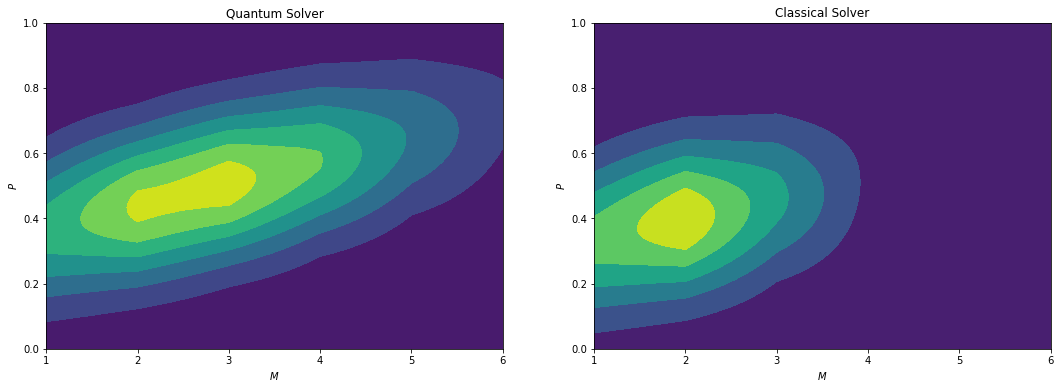

In [182]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
## 2 D gaussian code taken from https://stackoverflow.com/questions/28342968/how-to-plot-a-2d-gaussian-with-different-sigma
# Our 2-dimensional distribution will be over variables X and Y
N = 100
X = np.linspace(1, depth+1, depth+1)
Y = np.linspace(0, 1, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
ZQ = multivariate_gaussian(pos, muQ, covQ)

ZC = multivariate_gaussian(pos, muC, covC)
# plot using subplots
fig,ax = plt.subplots(1,2,figsize=(18,6))


ax[0].contourf(X, Y, ZQ,cmap=cm.viridis)
ax[0].set_xlabel(r'$M$')
ax[0].set_ylabel(r'$P$')
ax[0].set_title("Quantum Solver")
ax[1].contourf(X, Y, ZC,cmap=cm.viridis)
ax[1].set_xlabel(r'$M$')
ax[1].set_ylabel(r'$P$')
ax[1].set_title("Classical Solver")
plt.show()

Now we have the distribution of parameters $P$ and $M$ from the set of random scrambles. We have assumed it is gaussian and only calculated 2 moments, this might be a terrible assumption, but we keep it for now. 

To find the distribution over solve move count we need to integrate over this distribution of parameters

$$P(x) = \sum_M\int dP P(x|P,M)P(P,M)$$
We just found $P(P,M)$ and we know $P(x = n/M|P,M) = Geo(P)$

In [517]:
import pandas as pd
dfQ = pd.DataFrame({'M': dataQ[0],'P':dataQ[1]})
dfC = pd.DataFrame({'M': dataC[0],'P':dataC[1]})

N = 50
Mvals = np.linspace(1,depth+1,depth+1)
Pvals = np.linspace(0,1,N)

dfQ = dfQ.sort_values(by=['M','P'])
dfC = dfC.sort_values(by=['M','P'])
countsQ = np.zeros([len(Pvals),depth+1])
countsC = np.zeros([len(Pvals),depth+1])
totalcounted = 0
for j,M in enumerate(Mvals):
    margQ = dfQ.loc[dfQ['M']==M].get('P')
    margC = dfC.loc[dfC['M']==M].get('P')
    for i,p in enumerate(Pvals):
        for data in margQ:
            if (p<=1):
                if (data > p and data<=Pvals[i+1]):
                    countsQ[i,j]+= 1
        for data in margC:
            if (p<=1):
                if (data > p and data<=Pvals[i+1]):
                    countsC[i,j]+= 1
ZQ = countsQ/Num_scrambles
ZC = countsC/Num_scrambles
np.sum(np.sum(ZQ,axis=0))

1.0000000000000004

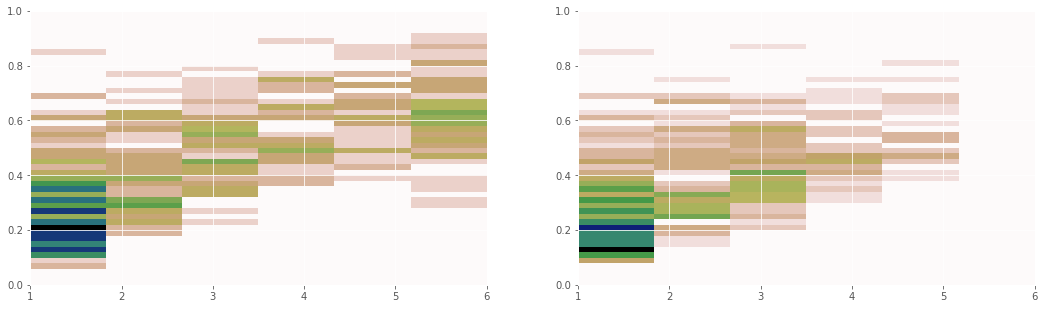

In [518]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].imshow(ZQ, cmap=plt.R,
          extent=[1, depth+1, 0, 1],origin='lower',aspect = 3)
ax[1].imshow(ZC, cmap=plt.cm.gist_earth_r,
          extent=[1, depth+1, 0, 1],origin='lower',aspect = 3)
plt.show()

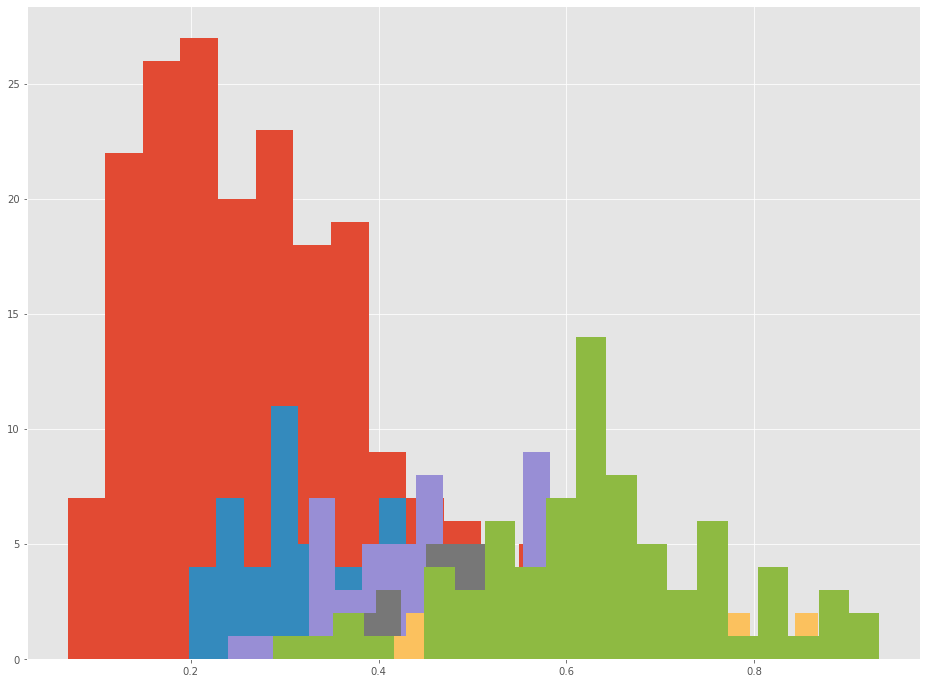

In [519]:
for j,M in enumerate(Mvals):
    margQ = dfQ.loc[dfQ['M']==M].get('P')
    margQ.hist(bins=20)
    # margC = dfQ.loc[dfC['M']==M].get('P')
    # margC.hist(bins=20)

In [553]:
def conditionalGeo(n,M,P):
    if (n/M == n//M):
        return (1-P)**(n//M-1)*P
    return 0

def Prob(x,Z):
    psum = 0
    for i,m in enumerate(Mvals):
        for j,p in enumerate(Pvals):
            psum += conditionalGeo(x,m,p) * Z[j,i]
    return psum

distQ = []
distC = []
meanQ = 0
meanC = 0

xvals = range(1,1000)
for x in xvals:
    P_x_Q = Prob(x,ZQ)
    P_x_C = Prob(x,ZC)
    distQ.append(P_x_Q)
    distC.append(P_x_C)
    meanQ += x*P_x_Q
    meanC += x*P_x_C
print(meanQ,meanC)
print(sum(distQ),sum(distC))

6.41926367308513 6.214956971824007
0.9999999999999979 0.999999999999999


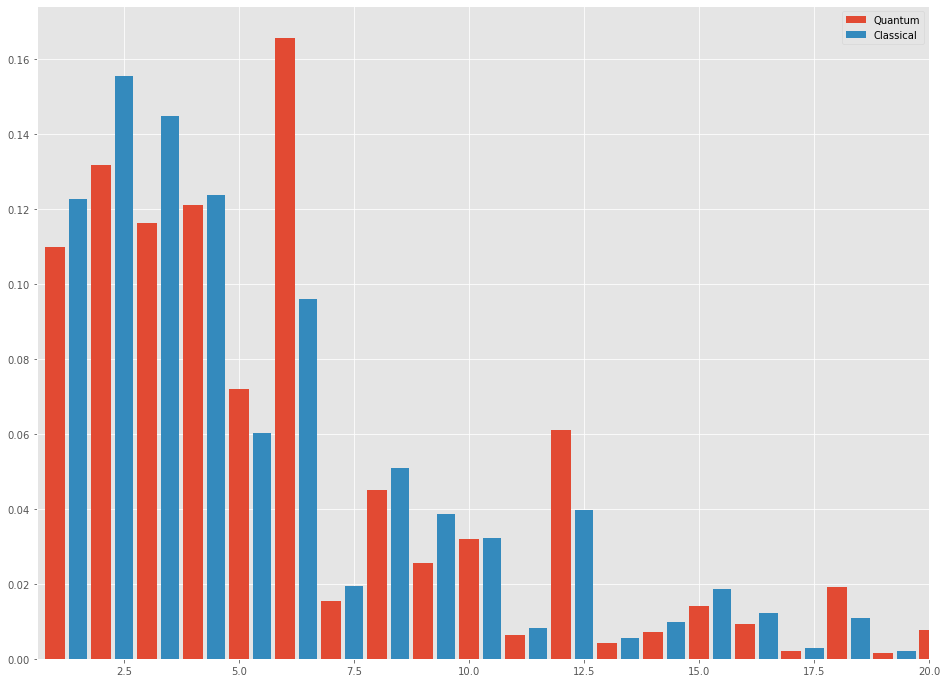

In [545]:
plt.bar(xvals,distQ,width=.44)
plt.bar([x+.5 for x in xvals],distC,width=.4,)
plt.xlim([.6,20])
plt.legend(["Quantum","Classical"])

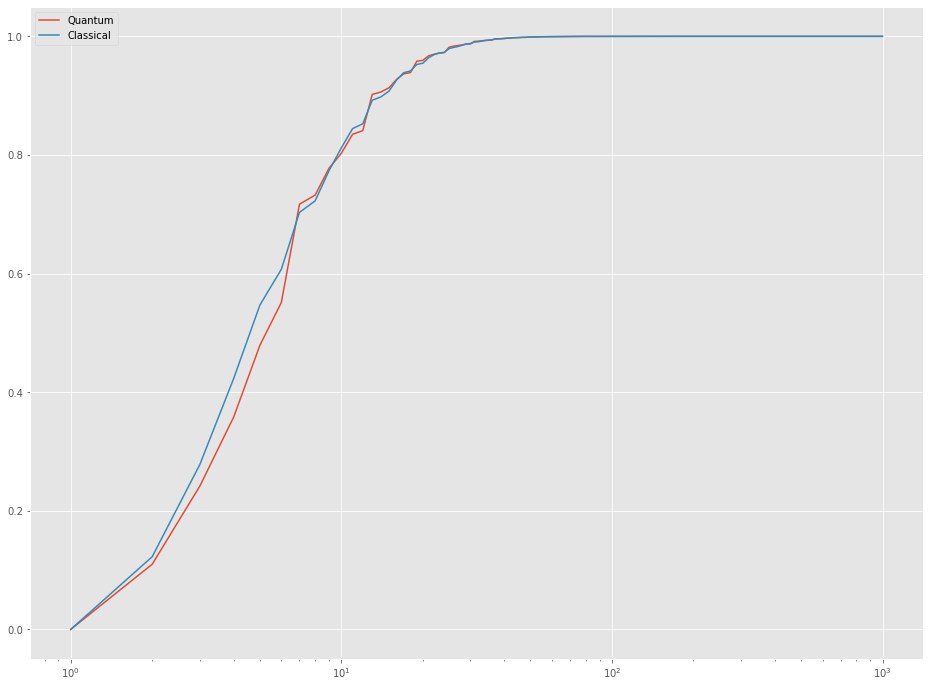

In [554]:
plt.semilogx(xvals,[sum(distQ[0:n]) for n in range(len(distQ))])
plt.semilogx(xvals,[sum(distC[0:n]) for n in range(len(distC))])
#plt.bar([x+.5 for x in xvals],distC,width=.4,)
#plt.xlim([1,20])
plt.legend(["Quantum","Classical"])

In [512]:
from scipy import stats

N = 100
Mvals = np.linspace(1,depth+1,depth+1)
Pvals = np.linspace(0,1,N)
X,Y = np.meshgrid(Mvals,Pvals)

positions = np.vstack([X.ravel(), Y.ravel()])
valuesQ = np.vstack([dataQ[0], dataQ[1]])
valuesC = np.vstack([dataC[0], dataC[1]])
kernelQ = stats.gaussian_kde(valuesQ)
kernelC = stats.gaussian_kde(valuesC)
ZQ = np.reshape(kernelQ(positions).T, X.shape)
ZC = np.reshape(kernelC(positions).T, X.shape)
print(np.sum(np.sum(ZQ/N,axis=0)),np.sum(np.sum(ZC/N,axis=0)))

0.8807514670648222 1.0140319961735376


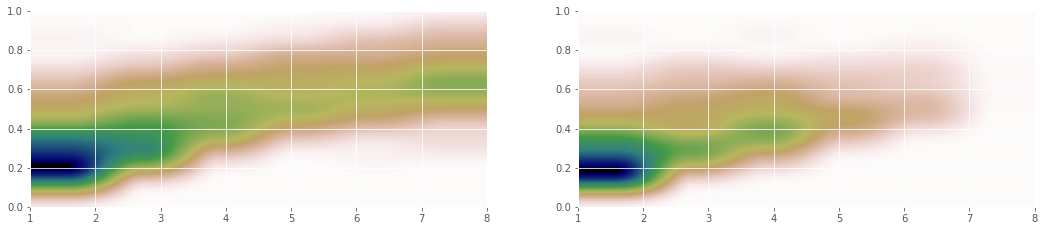

In [513]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].imshow(ZQ, cmap=plt.cm.gist_earth_r,
          extent=[1, depth+3, 0, 1],origin='lower',aspect = 3)
ax[1].imshow(ZC, cmap=plt.cm.gist_earth_r,
          extent=[1, depth+3, 0, 1],origin='lower',aspect = 3)
plt.show()

In [514]:



distQ = []
distC = []
meanQ = 0
meanC = 0

xvals = range(1,250)
for x in xvals:
    P_x_Q = Prob(x,ZQ)/N
    P_x_C = Prob(x,ZC)/N
    distQ.append(P_x_Q)
    distC.append(P_x_C)
    meanQ += x*P_x_Q
    meanC += x*P_x_C
print(meanQ,meanC)
print(sum(distQ),sum(distC))

5.808568314130641 6.454255076470733
0.8805011468221918 1.0136798185590172


## Finding performance of optimal strategy for reseting puzzle

In [22]:
def hash_func(state):
    string = ''
    temp = np.round(canonical_phase(state),8)
    for coeff in temp:
        if np.real(coeff) == 0 :
            string += '[0.]'
        else:
            string +=   str(np.real(coeff))
        if np.imag(coeff) == 0:
            string += '[0.]'
        else:
            string += str(np.imag(coeff))
        
    return string

def canonical_phase(state):
    #phase choosen so that the first nonzero element is positive
    for coeff in state:
        if not math.isclose(np.abs(coeff),0):
            phase = np.angle(coeff)
            break
    return state / np.exp(1j*phase)

def GeoMean(state,m):
    P = np.abs(state[0])**2
    return m/P

In [581]:
def optimal_search(scramble,move_set,Cost,max_depth = 100):
    move_cost = Cost[0]
    meas_cost = Cost[1]
    group = {hash_func(scramble):scramble}
    new_elems = group
    depth = 0
    best  = GeoMean(scramble,depth+meas_cost)
    best_depth = depth+meas_cost
    best_prob = 1/best*best_depth
    while((depth+meas_cost)<min(best,max_depth)):
        current_group = new_elems.copy()
        new_elems = {}
        for g in move_set:
            # iterate through the group
            for key in current_group: 
                state = g@current_group[key]
                hashed = hash_func(state)
                if not (hashed in group):
                    new_elems.update({hashed:state}) 
                    group.update({hashed:state})
                    if(GeoMean(state,depth+move_cost+meas_cost)< best):
                        best = GeoMean(state,depth+move_cost+meas_cost)
                        best_depth = depth+move_cost+meas_cost
                        best_prob = 1/best*best_depth
        depth += move_cost
    return [best_depth,best_prob]

def Sample_scrambles_opt(Scrambles,move_set,Cost,max_depth=100):
    P_samples = []
    M_samples = []
    for i,scramble in enumerate(Scrambles):
        [M,P] = optimal_search(scramble,move_set,Cost,max_depth)
        P_samples.append(P[0])
        M_samples.append(M)
        if(i/len(Scrambles)%.1< (i-1)/len(Scrambles)%.1):
            print("Progress:", i/len(Scrambles))
    return [np.array(M_samples),np.array(P_samples[:][:])]


In [700]:
Costs = [1,1]

In [736]:
dataQ = Sample_scrambles_opt(Scrambles,QS,Costs,max_depth = 9)

Progress: 0.0
Progress: 0.1
Progress: 0.2
Progress: 0.3005
Progress: 0.4
Progress: 0.5005
Progress: 0.6005
Progress: 0.7005
Progress: 0.8
Progress: 0.9005


In [737]:
dataC = Sample_scrambles_opt(Scrambles,CS,Costs)

Progress: 0.0
Progress: 0.1
Progress: 0.2
Progress: 0.3005
Progress: 0.4
Progress: 0.5005
Progress: 0.6005
Progress: 0.7005
Progress: 0.8
Progress: 0.9005


In [738]:
dbfile = open('Data/QuantumOptimal_WithSwaps_2000', 'ab')
     
pickle.dump(dataQ, dbfile) 
dbfile.close()
                  
dbfile = open('Data/ClassicalOptimal_WithSwaps_2000', 'ab')
     
pickle.dump(dataC, dbfile) 
dbfile.close()

# dbfile = open('Data/QuantumOptimal_2000', 'ab')
     
# pickle.dump(dataM, dbfile) 
# dbfile.close()

### Analyzing the data

In [10]:
dbfile = open('Data/QuantumOptimal_WithSwaps_2000', 'rb')    
dataQ = pickle.load(dbfile)
dbfile.close()

dbfile = open('Data/ClassicalOptimal_WithSwaps_2000', 'rb')    
dataC = pickle.load(dbfile)
dbfile.close()

In [21]:
def conditionalGeo(n,M,P):
    if (n/M == n//M):
        return (1-P)**(n//M-1)*P
    return 0

def Prob(x,Z):
    psum = 0
    for i,m in enumerate(Mvals):
        for j,p in enumerate(Pvals):
            psum += conditionalGeo(x,m,p) * Z[j,i]
    return psum

In [27]:
dfQ = pd.DataFrame({'M': dataQ[0],'P':dataQ[1]})
dfC = pd.DataFrame({'M': dataC[0],'P':dataC[1]})
depth = 20
Num_scrambles = len(dataQ[0])
Costs = [1,1]
# choosing number of bins according to Scott's Rule
std = np.std(dataQ[1])
N = int(np.round(Num_scrambles**(1/3)/(3.49*std)))
#N = int(np.round(2*Num_scrambles**(1/3)))
Mvals = np.linspace(Costs[1],depth*Costs[0]+Costs[1],depth*Costs[0]+1)
Pvals = np.linspace(0,1,N)

dfQ = dfQ.sort_values(by=['M','P'])
dfC = dfC.sort_values(by=['M','P'])
countsQ = np.zeros([len(Pvals),depth+1])
countsC = np.zeros([len(Pvals),depth+1])
totalcounted = 0
for j,M in enumerate(Mvals):
    margQ = dfQ.loc[dfQ['M']==M].get('P')
    margC = dfC.loc[dfC['M']==M].get('P')
    for i,p in enumerate(Pvals):
        for data in margQ:
            if (p<=1):
                if (data > p and data<=Pvals[i+1]):
                    countsQ[i,j]+= 1
        for data in margC:
            if (p<=1):
                if (data > p and data<=Pvals[i+1]):
                    countsC[i,j]+= 1
ZQ = countsQ/Num_scrambles
ZC = countsC/Num_scrambles

distQ = []
distC = []
meanQ = 0
meanC = 0

xvals = range(1,100)
for x in xvals:
    P_x_Q = Prob(x,ZQ)
    P_x_C = Prob(x,ZC)
    distQ.append(P_x_Q)
    distC.append(P_x_C)
    meanQ += x*P_x_Q
    meanC += x*P_x_C
print(meanQ,meanC)
print(sum(distQ),sum(distC))

5.4524528009951645 6.627480530491385
0.9999985555151389 0.9999130636220372


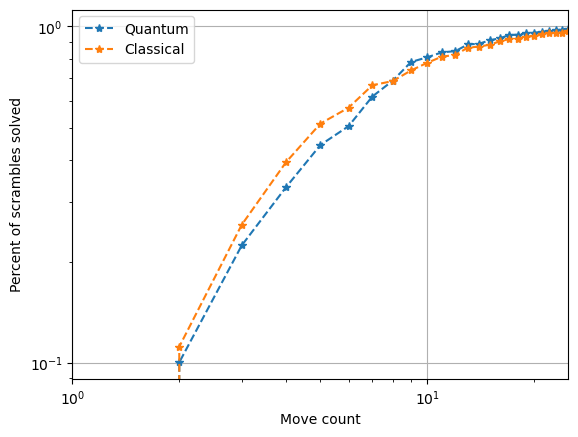

In [763]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.loglog(xvals,[sum(distQ[0:n]) for n in range(len(distQ))],'--*')
plt.semilogx(xvals,[sum(distC[0:n]) for n in range(len(distC))],'--*')
#plt.bar([x+.5 for x in xvals],distC,width=.4,)
plt.xlim([1,25])
#plt.plot([meanQ],[0.59],'o',color="blue")
#plt.plot([meanC],[.67],'o',color="orange")
plt.legend(["Quantum","Classical"])
plt.ylabel("Percent of scrambles solved")
plt.xlabel("Move count")
plt.grid()
# plt.plot([np.median(dataQ[0]/dataQ[1]),np.median(dataQ[0]/dataQ[1])],[0,1])
# plt.plot([0,10],[.5,.5])
# plt.plot([np.median(dataC[0]/dataC[1]),np.median(dataC[0]/dataC[1])],[0,1])
plt.savefig("./SolvingCDF_noswap.pdf",format="pdf")

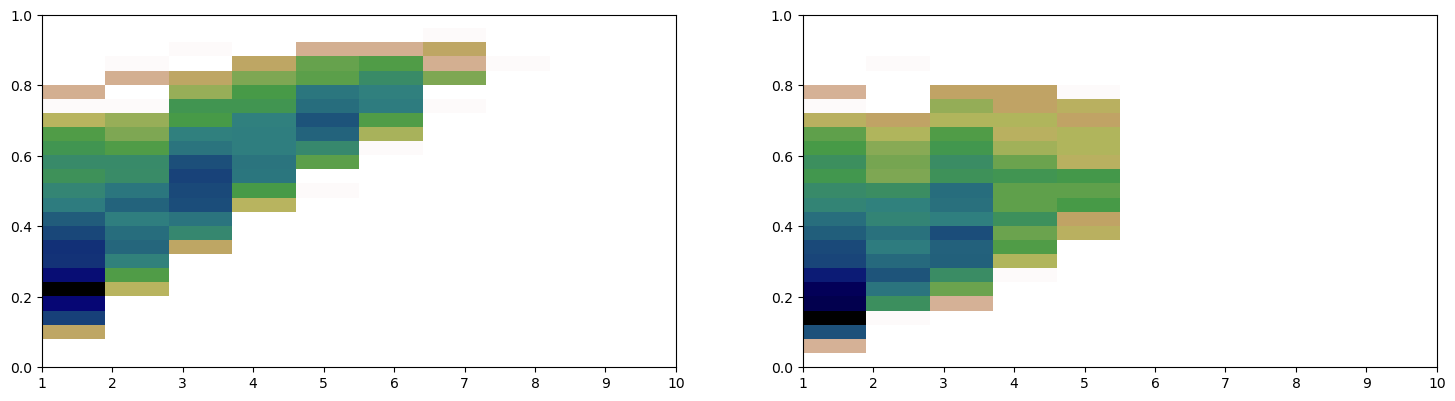

In [741]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].imshow(ZQ, cmap=plt.cm.gist_earth_r,
          extent=[1, depth+1, 0, 1],origin='lower',aspect = 5,norm=LogNorm())
ax[1].imshow(ZC, cmap=plt.cm.gist_earth_r,
          extent=[1, depth+1, 0, 1],origin='lower',aspect = 5,norm=LogNorm())
plt.show()

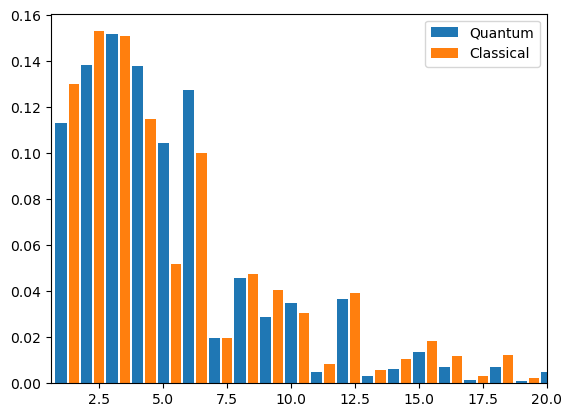

In [742]:
plt.bar(xvals,distQ,width=.44)
plt.bar([x+.5 for x in xvals],distC,width=.4,)
plt.xlim([.6,20])
plt.legend(["Quantum","Classical"])

In [731]:
print(np.mean(dataQ[0]/dataQ[1]),np.mean(dataC[0]/dataC[1]))
print(np.median(dataQ[0]/dataQ[1]),np.median(dataC[0]/dataC[1]))

5.050317639778697 5.8058175874640146
5.108520551322911 5.508116832745161


In [ ]:
plt.plot(distQ